# Projet création d'un agent IA Crypto

Ce projet construit un Agent Crypto complet utilisant :

LangGraph

Tools externes : prix, news, reddit

Agents internes : technical, fundamental, sentiment

Fusion layer

Mémoire

Rapport final

Tout tient dans un seul fichier.

🧠 Quel problème notre agent résout ?

Le marché crypto est saturé d’informations : prix en temps réel, centaines d’articles par jour, milliers d’avis Reddit, volatilité extrême.
Un investisseur particulier n’a ni le temps ni les outils pour analyser ces données de manière fiable.

➡️ 70% des investisseurs crypto déclarent prendre des décisions basées sur des émotions et des rumeurs (source : Binance Research).
➡️ De plus, le marché génère plus de 1,5 million de posts Reddit crypto par mois, impossibles à filtrer manuellement.

📌 Notre agent vient résoudre ce chaos en :

Collectant automatiquement les données clés (prix, news, opinions Reddit).

Produisant 3 analyses spécialisées (technique, fondamentale, sentiment).

Fusionnant les insights pour générer un rapport clair, actionnable et cohérent.

Éliminant les contradictions entre signaux et détectant les anomalies (volatilité, fake hype, etc.).

🎯 En résumé :

Notre agent transforme un flux d’informations ingérable en une recommandation synthétique, transparente et automatisée, permettant de décider 10× plus vite et avec moins de biais émotionnels.

## Imports Globaux

In [205]:
import os
import requests
from langchain.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END, START


from langchain_community.utilities import GoogleSearchAPIWrapper

from dotenv import load_dotenv
load_dotenv()  
# 🔥 Force absolument la clé OpenAI dans l'environnement
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [206]:
print(os.getenv("OPENAI_API_KEY"))

## State (data structure)

In [ ]:
from typing import TypedDict, Optional, List, Dict


class CryptoState(TypedDict, total=False):
    query: str
    intent: str


    price_data: Optional[Dict]
    news_data: Optional[List]
    reddit_data: Optional[List]


    technical_analysis: Optional[str]
    fundamental_analysis: Optional[str]
    sentiment_analysis: Optional[str]


    fusion_output: Optional[str]
    final_report: Optional[str]

## Tools

### Price Tool

In [208]:
from langchain.tools import tool
import requests

@tool
def get_crypto_price(asset: str) -> dict:
    """
    Fetch crypto price & market data from the CoinGecko API.
    Returns price, market cap, 24h volatility and supply.
    """
    url = f"https://api.coingecko.com/api/v3/coins/{asset.lower()}"

    try:
        r = requests.get(url, timeout=10)
    except Exception as e:
        return {"error": f"Request failed: {e}"}

    if r.status_code != 200:
        return {"error": f"Crypto not found or API error ({r.status_code})"}

    data = r.json()

    try:
        market = data["market_data"]
        return {
            "name": data.get("name"),
            "symbol": data.get("symbol"),
            "price_usd": market["current_price"].get("usd"),
            "market_cap": market["market_cap"].get("usd"),
            "volatility_24h": market.get("price_change_percentage_24h"),
            "supply": market.get("circulating_supply"),
        }
    except Exception:
        return {"error": "Unexpected API structure"}

### News Tool

In [209]:
import os
from tavily import TavilyClient
from langchain.tools import tool

# Pas besoin d'API key pour le free tier (Tavily autorise l'usage sans clé)
client = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))

def tavily_search_raw(query: str, max_results: int = 5) -> dict:
    """
    Effectue une recherche Tavily et retourne du JSON brut.
    Compatible avec toutes les versions de Tavily + LangChain.
    """
    print(f"🔎 Tavily searching: {query} ...")
    return client.search(query=query, max_results=max_results)

def format_tavily_results(results: dict, max_content_chars: int = 2000) -> str:
    """
    Transforme les résultats Tavily en texte propre pour le LLM.
    """
    out = []
    for i, r in enumerate(results.get("results", []), start=1):
        title = r.get("title") or ""
        content = r.get("content") or r.get("raw_content") or ""

        if len(content) > max_content_chars:
            content = content[:max_content_chars] + "…"

        out.append(f"Source {i}:\nTitle: {title}\nContent: {content}\n")

    return "\n".join(out)


In [210]:
@tool
def get_crypto_news(query: str) -> str:
    """
    Search recent news about a crypto asset using Tavily Search,
    then format results into a readable string.
    """
    raw = tavily_search_raw(query + " crypto news", max_results=5)
    formatted = format_tavily_results(raw, max_content_chars=3000)
    return formatted

### Reddit Tool

In [211]:
import praw

# ⚠️ Remets ici TES vraies clés Reddit
reddit = praw.Reddit(
    client_id="LOMZo8eXlm3cpElm1BUAuw",
    client_secret="S_LHRKw9dBHqdBZRjZHfHsRdjlerww",
    user_agent="CryptoAgent/0.1"
)

@tool
def get_reddit_opinions(asset: str) -> list:
    """
    Récupère les top posts Reddit contenant le nom de la crypto.
    """
    posts_data = []

    for post in reddit.subreddit("all").search(f"{asset} crypto", limit=5):
        posts_data.append({
            "title": post.title,
            "score": post.score,
            "comments": post.num_comments,
            "url": post.url
        })

    return posts_data

In [213]:
def truncate(text, max_chars=1000):
    return text[:max_chars] + "..." if len(text) > max_chars else text

### Volatility alert

In [244]:
def volatility_alert(s):
    vol = s["price_data"].get("volatility_24h")

    if vol is None:
        return {**s, "risk_alert": "❓ Unable to evaluate volatility (missing data)"}

    # SEUIL : marché crypto considéré très volatil au-delà de ±5%
    if abs(vol) > 5:
        return {
            **s,
            "risk_alert": f"⚠️ High volatility detected: {vol:.2f}% in the last 24h"
        }
    
    return {
        **s,
        "risk_alert": f"Market stable (24h change: {vol:.2f}%)"
    }

def is_high_vol(state):
    alert = state.get("risk_alert", "")
    return alert.startswith("⚠️")

### Market regime detector (bear/bull)

In [232]:
def detect_market_regime(s):
    price = s["price_data"].get("price_usd")
    vol = s["price_data"].get("volatility_24h")

    if price is None or vol is None:
        return {**s, "regime": "unknown"}

    # Règles simples mais efficaces
    if vol > 5:
        regime = "bull"
    elif vol < -5:
        regime = "bear"
    else:
        regime = "crab"  # marché en range

    return {**s, "regime": regime}

### Hype detector

In [246]:
def hype_detector(s):
    sentiment = s["sentiment_analysis"].get("score", 0)
    news_score = s["fundamental_analysis"].get("news_score", 0)

    if sentiment > 0.6 and news_score < 0:
        hype = True
        message = "⚠️ Possible hype / pump detected: positive sentiment but negative news."
    else:
        hype = False
        message = "No hype detected."

    return {**s, "hype_flag": hype, "hype_message": message}

def is_hype(s):
    sentiment = s["sentiment_analysis"].get("score", 0)
    news_score = s["fundamental_analysis"].get("news_score", 0)
    return sentiment > 0.6 and news_score < 0


### Confidence score 

In [239]:
def compute_confidence(s):

    score = 100

    # Risque : volatilité
    vol = abs(s["price_data"].get("volatility_24h", 0))
    if vol > 10: score -= 30
    elif vol > 5: score -= 15

    # Risque : hype détecté
    if s.get("hype_flag"):
        score -= 25

    # Risque : marché baissier
    if s.get("regime") == "bear":
        score -= 15

    # Limiter entre 0 et 100
    score = max(0, min(100, score))

    return {**s, "confidence_score": score}

## Agents

### Technical Agent

In [247]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model_name="gpt-4", temperature=0.4)


def technical_agent(price_data):
    price_data = truncate(price_data, 800)
    prompt = f"""
    Analyse numérique et technique simple : tendance, volatilité.
    Données de prix : {price_data}
    ⚠️ Ne pas inclure de disclaimers ou avertissements financiers.
    """
    return llm.invoke(prompt).content

### Fundamental Agent

In [245]:
import re

def extract_news_score(text):
    match = re.search(r"NEWS_SCORE:\s*(-?\d+\.?\d*)", text)
    if match:
        try:
            val = float(match.group(1))
            return max(-1, min(1, val))  # clamp entre -1 et +1
        except:
            pass
    return 0.0

def fundamental_agent(price_data, news_data):
    """
    Analyse fondamentale basée sur :
    - news sentiment
    - narrative du marché
    - impact sur l'actif

    Renvoie :
    - analysis : résumé structuré
    - news_score : entre -1 (très négatif) et +1 (très positif)
    """

    # 1) Fusionner les news dans un seul texte
    news_text = "\n\n".join([n["title"] + " - " + n.get("description", "") for n in news_data])

    # 2) Prompt qui impose un score numérique
    prompt = [
        {
            "role": "system",
            "content": (
                "You are a crypto fundamental analysis bot. "
                "Your job is to analyze news sentiment, market narratives, "
                "and real-world catalysts. "
                "You MUST output a numeric score between -1 (very negative news) "
                "and +1 (very positive news). "
                "Include exactly ONE line: NEWS_SCORE: <number>"
            )
        },
        {
            "role": "user",
            "content": (
                f"Analyze these news about the asset:\n\n{news_text}\n\n"
                "Provide:\n"
                "- A structured summary of the news\n"
                "- ONE line with: NEWS_SCORE: <number>\n"
                "Do NOT include financial disclaimers."
            )
        }
    ]

    # 3) LLM invocation
    result = llm.invoke(prompt).content

    # 4) Extraction du score
    score = extract_news_score(result)

    return {
        "analysis": result,
        "news_score": score
    }


### Sentiment Agent

In [ ]:
def extract_sentiment_score(text):
    try:
        # Tu mets ce que ton modèle renvoie réellement
        # Exemple: "Sentiment score: 0.65"
        for token in text.split():
            try:
                val = float(token)
                if -1 <= val <= 1:
                    return val
            except:
                pass
    except:
        pass
    return 0

def sentiment_agent(reddit_data):
    """
    Analyse le sentiment Reddit (FUD/FOMO) et renvoie :
    - summary : résumé qualitatif
    - score : sentiment numérique entre -1 (bearish) et +1 (bullish)
    """

    # 1) Réduire la taille (pour éviter dépassement du contexte)
    reddit_text = truncate("\n".join(reddit_data), 1200)

    # 2) Prompt spécialisé Crypto : FUD / FOMO + score numérique obligatoire
    prompt = [
        {
            "role": "system",
            "content": (
                "You are a crypto sentiment analysis bot. "
                "You specialize in detecting FUD (fear, uncertainty, doubt), "
                "FOMO (fear of missing out), and general sentiment intensity. "
                "Classify the sentiment numerically between -1 (very bearish) and +1 (very bullish). "
                "Your output MUST include exactly one line formatted as: SENTIMENT_SCORE: <number>"
            )
        },
        {
            "role": "user",
            "content": (
                "Analyze the following Reddit posts:\n\n"
                f"{reddit_text}\n\n"
                "Provide:\n"
                "- A short summary of sentiment (FUD/FOMO / bullish/bearish)\n"
                "- Then one line with: SENTIMENT_SCORE: <number>\n"
                "Do NOT include financial disclaimers."
            )
        }
    ]

    # 3) LLM Invocation
    result = llm.invoke(prompt).content

    # 4) Extraction du score numérique
    score = extract_sentiment_score(result)

    return {
        "summary": result,
        "score": score
    }

## Fusion Master

In [ ]:
def fusion_master(technical, fundamental, sentiment, hype_flag=False, risk_alert="", regime="unknown"):
    """
    Combine toutes les analyses en un résumé structuré
    et demande au LLM de donner un score final entre 0 et 5.
    """

    # Scores extraits
    t_score = technical.get("technical_score", 0)
    f_score = fundamental.get("news_score", 0)
    s_score = sentiment.get("score", 0)

    # Résumé structuré
    combined_analysis = f"""
    === INPUTS POUR NOTATION CRYPTO ===

    -- Technique --
    Trend : {technical.get("trend", "unknown")}
    Score technique : {t_score}
    Résumé technique : {technical.get("summary", "")}

    -- Fondamentale (News) --
    Score news : {f_score}
    Résumé fondamentale : {fundamental.get("analysis", "")}

    -- Sentiment Reddit --
    Score sentiment : {s_score}
    Résumé sentiment : {sentiment.get("summary", "")}

    -- Risques --
    Hype détecté : {hype_flag}
    Volatilité : {risk_alert}
    Régime de marché : {regime}
    """

    # Prompt LLM : demande uniquement un score entre 0 et 5
    prompt = [
        {
            "role": "system",
            "content": (
                "You are a crypto rating assistant. "
                "Your ONLY job is to give a global quality score for the cryptocurrency "
                "between 0 and 5 (0 = extremely bad, 5 = extremely positive). "
                "You MUST respond with EXACTLY one line: RATING: <number between 0 and 5>. "
                "No text, no explanation, no commentary."
            )
        },
        {
            "role": "user",
            "content": combined_analysis
        }
    ]

    # Appel LLM
    response = llm.invoke(prompt).content

    # Extraction du score
    import re
    match = re.search(r"RATING:\s*(\d+\.?\d*)", response)
    if match:
        rating = float(match.group(1))
        rating = max(0, min(5, rating))  # clamp pour sécurité
    else:
        rating = 2.5  # fallback neutre

    return {
        "rating": rating,
        "llm_output": response,
        "combined_inputs": combined_analysis
    }

## Report Generator

In [ ]:
def report_generator(crypto_name, fusion_output, technical, fundamental, sentiment):
    """
    Produit un rapport structuré et lisible basé sur les sorties textuelles
    des agents (fusion, technique, fondamentale, sentiment).
    Tous les paramètres sont de simples chaînes de texte.
    """
    return f"""
    📊 Rapport final pour {crypto_name}

    ---

    ⭐ 1. Score global (Fusion Analysis)

    {fusion_output}

    ---

    📈 2. Analyse Technique

    {technical}

    ---

    🧩 3. Analyse Fondamentale

    {fundamental}

    ---

    😶‍🌫️ 4. Sentiment du Marché
    
    {sentiment}

    ---
    ️⚠️ Ceci est un conseil financier. Faites pas vos propres recherches.
    """


## Memory

In [220]:
MEMORY = {}


def memory_writer(state):
    MEMORY[state["query"]] = state["final_report"]
    return state

## Graph LangGraph

In [242]:
graph = StateGraph(CryptoState)


# Tools
graph.add_node(
    "price",
    lambda s: { "price_data": get_crypto_price.run(s["query"]) }
)

graph.add_node(
    "news",
    lambda s: { "news_data": get_crypto_news.run(s["query"]) }
)

graph.add_node(
    "reddit",
    lambda s: { "reddit_data": get_reddit_opinions.run(s["query"]) }
)

# Analyses
graph.add_node("technical", lambda s: {**s, "technical_analysis": technical_agent(s["price_data"])})
graph.add_node("fundamental", lambda s: {**s, "fundamental_analysis": fundamental_agent(s["price_data"], s["news_data"])})
graph.add_node("sentiment", lambda s: {**s, "sentiment_analysis": sentiment_agent(s["reddit_data"])})

# Fusion
graph.add_node("fusion", lambda s: {**s, "fusion_output": fusion_master(s["technical_analysis"], s["fundamental_analysis"], s["sentiment_analysis"])})

graph.add_node(
    "report",
    lambda s: {
        **s,
        "final_report": report_generator(
            s["query"],
            s["fusion_output"],
            s["technical_analysis"],
            s["fundamental_analysis"],
            s["sentiment_analysis"]
        )
    }
)
graph.add_node("volatility_alert", volatility_alert)
graph.add_node("market_regime", detect_market_regime)
graph.add_node("hype_detector", hype_detector)
graph.add_node("confidence", compute_confidence)




# Memory
graph.add_node("memory", memory_writer)

# Edges

# === PHASE DATA ===
# Entry point
graph.set_entry_point("price")

# === PHASE 1 : Collecte de données ===
graph.add_edge(START, "news")
graph.add_edge(START, "price")
graph.add_edge(START, "reddit")

# === PHASE 2 : Analyses ===
graph.add_conditional_edges(
    "technical",
    is_high_vol,
    {
        True: "volatility_alert",   # Cas fort mouvement → analyse Risk Alert
        False: "fundamental"        # Cas normal → analyse fondamentale
    }
)
graph.add_edge("volatility_alert", "fundamental")
graph.add_conditional_edges(
    "sentiment",
    is_hype,
    {
        True: "hype_detector",
        False: "fusion"
    }
)
graph.add_edge("hype_detector", "fusion")

graph.add_edge("news", "technical")
graph.add_edge("price", "technical")
graph.add_edge("reddit", "technical")
graph.add_edge("price", "market_regime")
graph.add_edge("market_regime", "technical")
graph.add_edge("technical", "fundamental")
graph.add_edge("fundamental", "sentiment")

# === PHASE 3 : Fusion ===
graph.add_edge("sentiment", "fusion")

# === PHASE 4 : Rapport (génère final_report) ===
graph.add_edge("fusion", "confidence")
graph.add_edge("confidence", "report")

# === PHASE 5 : Interaction utilisateur ===
graph.add_edge("report", "memory")

# === Fin ===
graph.add_edge("memory", END)

crypto_agent = graph.compile()

## Exécution du programme

## Phase 1

In [222]:
query = input("Crypto à analyser : ")
res = crypto_agent.invoke({"query": query})
print(res["final_report"])

🔎 Tavily searching: bitcoin crypto news ...

    📊 **Rapport final pour bitcoin**

    ---

    ⭐ 1. Score global (Fusion Analysis)

    Rating: Basé sur l'analyse technique, fondamentale et du sentiment, le Bitcoin obtient un rating de 3 sur 5. 

La baisse des prix et la volatilité élevée indiquées par l'analyse technique peuvent être préoccupantes pour certains investisseurs. Cependant, l'analyse fondamentale reste solide avec une capitalisation boursière élevée et une adoption croissante. 

L'analyse du sentiment indique un climat de peur, d'incertitude et de doute, ce qui peut affecter négativement le marché. Cependant, il est important de noter que les sentiments du marché peuvent changer rapidement et ne sont pas toujours un indicateur fiable des performances futures.

En conclusion, bien que le Bitcoin présente actuellement une certaine instabilité, ses fondamentaux solides et son adoption croissante suggèrent un potentiel à long terme. Cependant, les investisseurs doivent faire

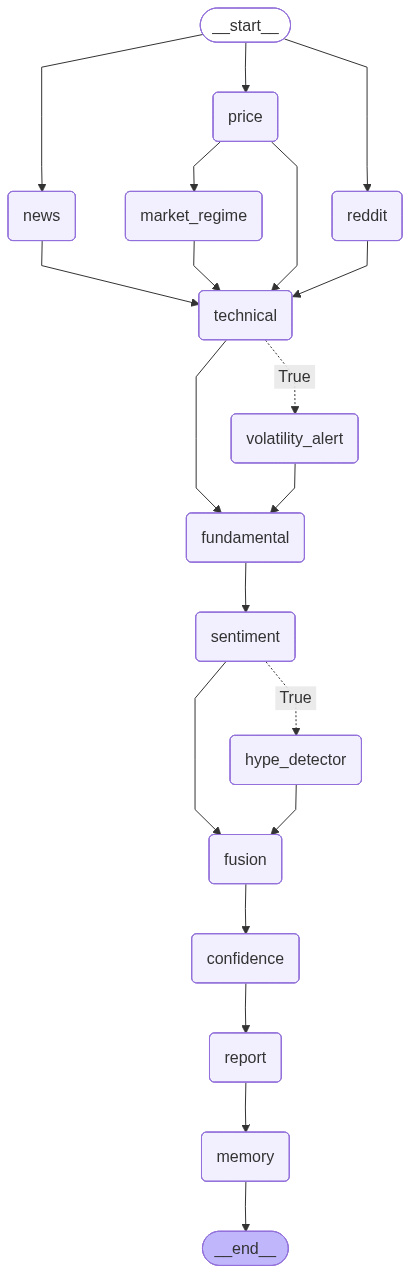

In [243]:
crypto_agent